[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [ ]:
%pip install transformers

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")



We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [HumanMessage(f"Hi I am a researcher on ocean mammals", name="Lance")]
messages.append(AIMessage(f"So you said you were researching ocean mammals?", name="Bot"))
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hi I am a researcher on ocean mammals
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_aws import ChatBedrock, ChatBedrockConverse   
llm = ChatBedrockConverse(model_id="us.amazon.nova-pro-v1:0", temperature=0,disable_streaming='tool_calling')
llm.invoke(messages)

AIMessage(content='There are many other fascinating ocean mammals to learn about besides whales. Here are some other ocean mammals you might find interesting:\n\n1. **Dolphins**:\n   - Highly intelligent and social creatures.\n   - Found in various species, such as bottlenose dolphins and orca (killer whales).\n\n2. **Porpoises**:\n   - Smaller and less well-known than dolphins.\n   - Often found in coastal waters.\n\n3. **Seals and Sea Lions**:\n   - Seals (true seals) and sea lions (eared seals) have different physical characteristics and behaviors.\n   - Seals have ear holes, while sea lions have external ear flaps.\n\n4. **Walruses**:\n   - Known for their large tusks and blubbery bodies.\n   - Typically found in the Arctic regions.\n\n5. **Manatees and Dugongs**:\n   - Herbivorous marine mammals.\n   - Often called "sea cows" due to their slow-moving, grazing habits.\n\n6. **Sea Otters**:\n   - Known for their playful behavior and use of tools.\n   - Spend most of their lives in w

We can run our chat model in a simple graph with `MessagesState`.

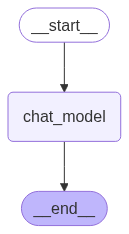

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hi I am a researcher on ocean mammals
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are a lot of mammals that live in the ocean. Some of them include:

1. Dolphins
2. Porpoises
3. Seals
4. Sea lions
5. Walruses
6. Manatees
7. Dugongs
8. Polar bears
9. Sea otters

These are just a few examples of the many ocean mammals that exist. Each of these animals has unique characteristics and adaptations that allow them to thrive in their aquatic environments. If you're interested in learning more about ocean mammals, I would recommend exploring each of these groups in m

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

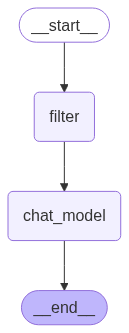

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-3]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [HumanMessage(f"Hi I am a researcher on ocean mammals", name="Lance")]
messages.append(AIMessage("Hi.", name="Bot", id="1"))
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Well, there are many other ocean mammals. Such as Dolphins, Walruses, Manatees, Seals and Sea Otters.


## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

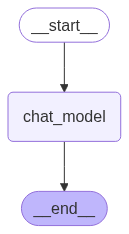

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hi I am a researcher on ocean mammals
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Well, there are many other ocean mammals. Such as Dolphins, Walruses, Manatees, Seals and Sea Otters.
================================ Human Message =================================
Name: Lance

Tell me more about Narwhals!


In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hi I am a researcher on ocean mammals
================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Well, there are many other ocean mammals. Such as Dolphins, Walruses, Manatees, Seals and Sea Otters.
================================ Human Message =================================
Name: Lance

Tell me more about Narwhals!
================================== Ai Message =======================

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

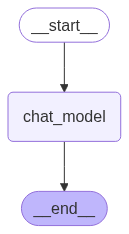

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatBedrock(model_id="us.amazon.nova-pro-v1:0"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
messages

[HumanMessage(content='Hi I am a researcher on ocean mammals', additional_kwargs={}, response_metadata={}, name='Lance', id='f3cffc0a-d338-4aa8-a481-c13b7aa95c83'),
 AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
 AIMessage(content='Well, there are many other ocean mammals. Such as Dolphins, Walruses, Manatees, Seals and Sea Otters.', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'a2f18e4d-9ade-422c-9d5b-47615ada8a34', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 09 Jun 2025 15:01:37 GMT', 'content-type': 'application/json', 'c

In [17]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=50,
            strategy="last",
            token_counter=ChatBedrock(model_id="us.amazon.nova-pro-v1:0"),
            allow_partial=True
        )

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


[AIMessage(content='\nNarwhals remain one of the most enigmatic creatures of the Arctic, captivating scientists and the public alike with their unique features and behaviors.', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '0aaa1fc5-1674-4627-80ff-23e7ed1fa085', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 09 Jun 2025 15:03:44 GMT', 'content-type': 'application/json', 'content-length': '2905', 'connection': 'keep-alive', 'x-amzn-requestid': '0aaa1fc5-1674-4627-80ff-23e7ed1fa085'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [5018]}, 'model_name': 'us.amazon.nova-pro-v1:0'}, id='run--ae7af80d-f660-47da-ab33-1c7a2994e340-0', usage_metadata={'input_tokens': 9, 'output_tokens': 660, 'total_tokens': 669}),
 HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [19]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r